Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Linear Regression...
Training Ridge Regression...
Training Lasso Regression...
Training Random Forest...
Training XGBoost...

📊 Model Performance Summary:
               Model  R2 Score    MAE
0  Linear Regression    0.9342  10.70
1   Ridge Regression    0.9342  10.70
2   Lasso Regression    0.9342  10.70
3      Random Forest    0.9088  12.48
4            XGBoost    0.8982  13.62


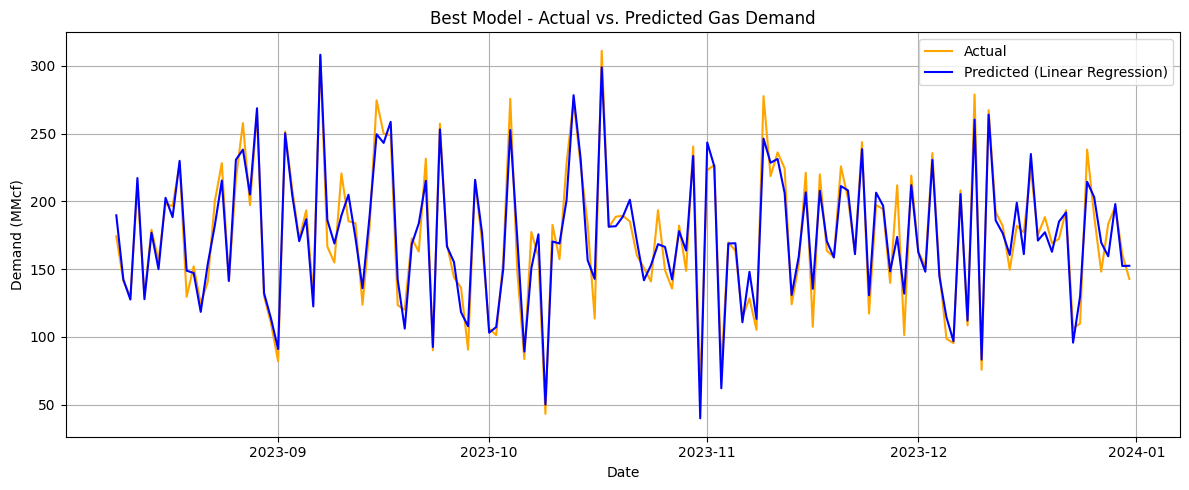

In [3]:
# 📦 Install dependencies (if needed)
!pip install scikit-learn xgboost --quiet

# 📥 Imports
import os
import pandas as pd
import matplotlib.pyplot as plt
from model import get_models, train_and_evaluate
from google.colab import drive
drive.mount('/content/drive')

# 📊 Load dataset
df = pd.read_csv("/content/drive/MyDrive/Weather Data Projects/modeling_dataset.csv", parse_dates=["date"])

# 🧠 Feature and target selection
features = ["HDD_rolling", "lag_demand", "day_of_week", "HDD_diff", "is_weekend", "demand_rolling"]
target = "demand"

# 🔁 Train all models and evaluate
models = get_models()
results = []

for model, name in models:
    print(f"Training {name}...")
    result = train_and_evaluate(model, name, df, features, target)
    results.append(result)

# 💾 Save metrics
metrics_df = pd.DataFrame([{
    "Model": r["model"],
    "R2 Score": r["r2_score"],
    "MAE": r["mae"]
} for r in results])

os.makedirs("outputs", exist_ok=True)
metrics_df.to_csv("/content/drive/MyDrive/Weather Data Projects/outputs/metrics.csv", index=False)

print("\n📊 Model Performance Summary:")
print(metrics_df)

# 📈 Plot best model predictions
best = max(results, key=lambda r: r["r2_score"])

plt.figure(figsize=(12, 5))
plt.plot(df["date"].iloc[-len(best["y_test"]):], best["y_test"], label="Actual", color="orange")
plt.plot(df["date"].iloc[-len(best["y_test"]):], best["y_pred"], label=f"Predicted ({best['model']})", color="blue")
plt.title("Best Model - Actual vs. Predicted Gas Demand")
plt.xlabel("Date")
plt.ylabel("Demand (MMcf)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

